# Exploratory Data Analysis

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns


### Import Data

In [2]:
path = os.getcwd()
path = path.replace('EDA', 'data_preprocessing')
files = os.listdir(path)
for file in files:
    if len(file.split('.csv'))>1:
        csv_path = path+'/'+file
data = pd.read_csv(csv_path)
data['date']=pd.to_datetime(data['date'])

In [3]:
data.head()

,date,domestic_market_contract_low,export_market_spot,domestic_market_spot,wtisplc,mcoilbrenteu,gasregm,impch,expch,prubbusdm,...,brazil_export,germany_export,united_kingdom_export,canada_import,usa_import,india_import,south_africa_import,germany_import,united_kingdom_import,japan_import
0,2000-01-01,41.0,NaN,NaN,27.18,25.51,1.289,6902.1,863.1,29.207387,...,10352529.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-02-01,41.0,NaN,NaN,29.35,27.78,1.377,6584.4,972.7,33.391099,...,8844172.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-03-01,45.0,NaN,NaN,29.89,27.49,1.516,6424.1,1330.5,30.941913,...,14091209.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-04-01,47.0,NaN,NaN,25.74,22.76,1.465,7070.5,1227.5,31.930148,...,14097518.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-05-01,47.0,NaN,NaN,28.78,27.74,1.487,7850.2,1526.3,31.201702,...,16762995.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### EDA for univariate ARIMA

In [20]:
uv_data = data[data.columns[:2]].set_index(data.columns[0])
uv_data =  uv_data.rename(columns = {data.columns[1]:'target'})
uv_data

,target
date,
2000-01-01,41.0
2000-02-01,41.0
2000-03-01,45.0
2000-04-01,47.0
2000-05-01,47.0
...,...
2022-08-01,93.0
2022-09-01,90.0
2022-10-01,90.0


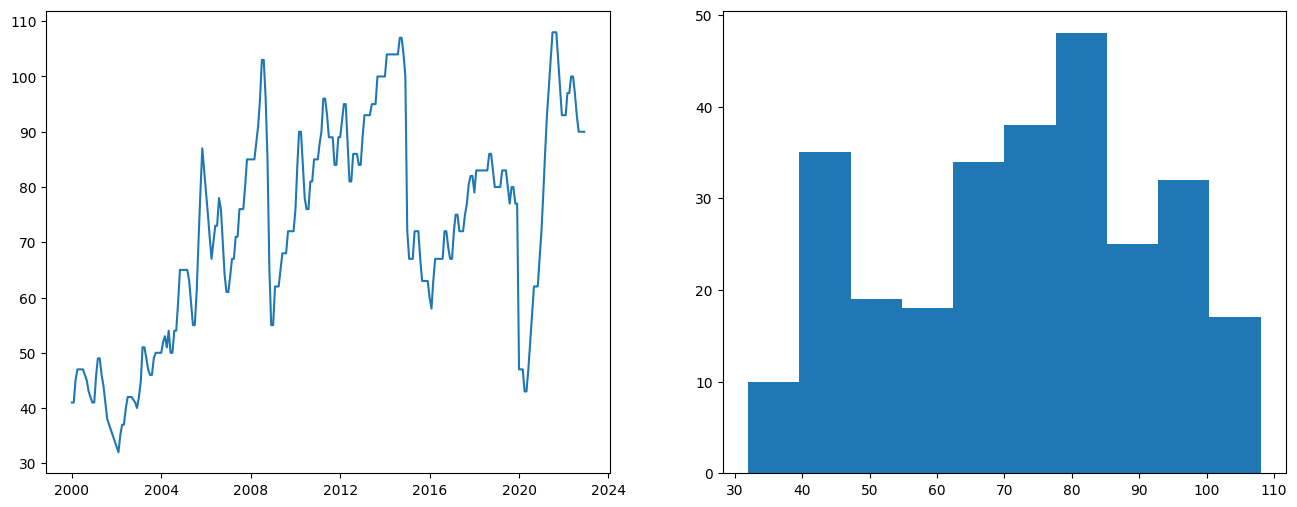

In [21]:
plt.figure(figsize = (16,6))

plt.subplot(1,2,1)
plt.plot(uv_data['target'])
plt.subplot(1,2,2)
plt.hist(uv_data['target'])
plt.show()

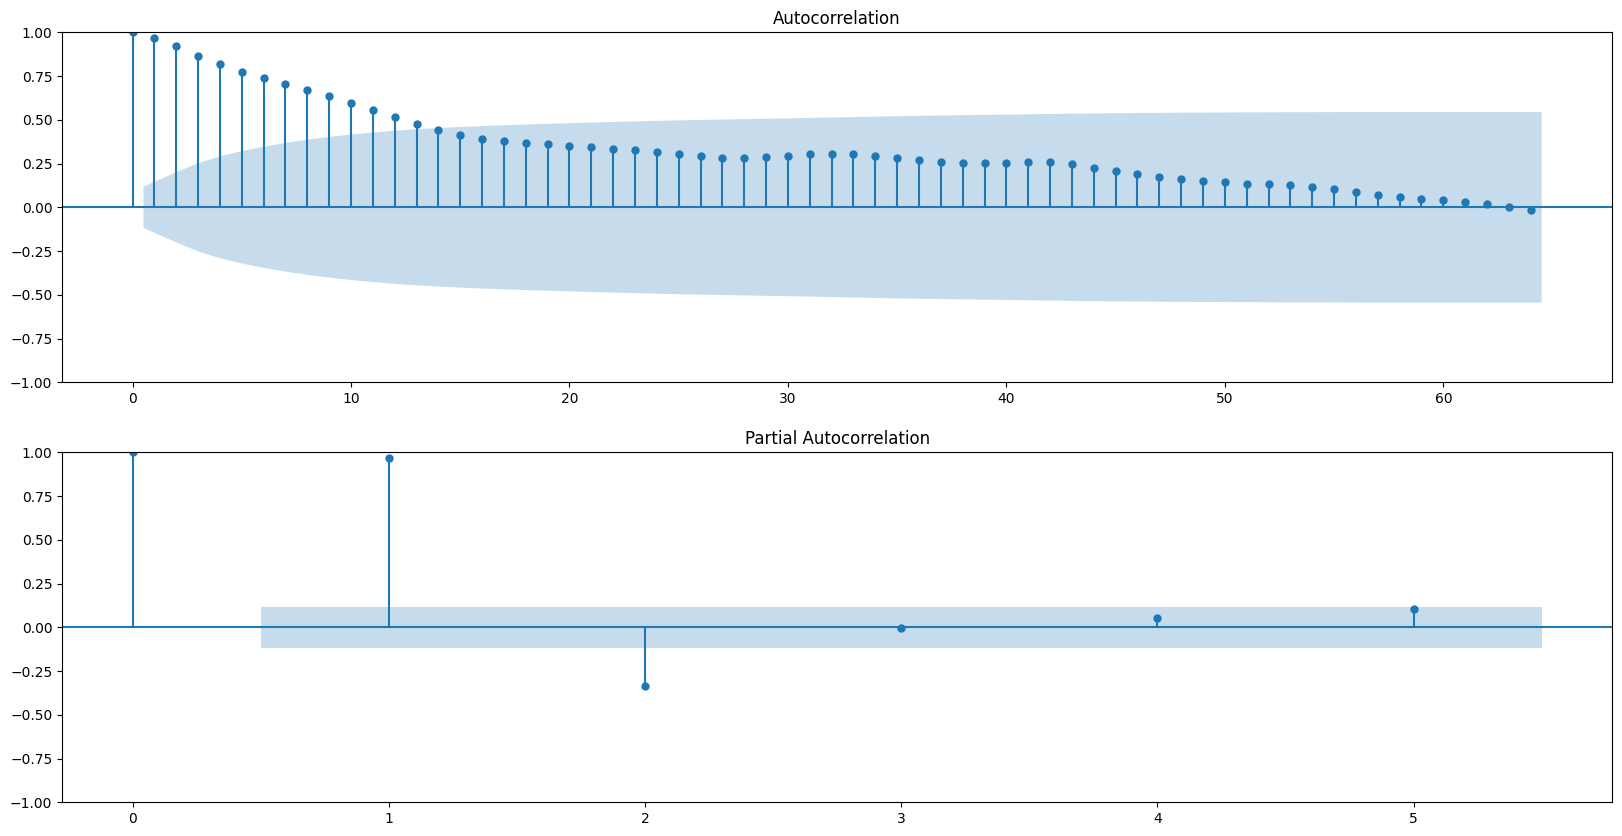

In [58]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10))

# Plot the ACF of the differenced series
plot_acf(uv_data, ax=ax1,lags=64)

# Plot the PACF of the differenced series
plot_pacf(uv_data, ax=ax2,lags=5)

plt.show()

In [23]:
# ARIMA requires the data to be stationary. We can check this by using Augmented Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
result = adfuller(uv_data['target'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.238045
p-value: 0.192728


Since, ADF value > -2.87 and p-value >0.05 we fail to reject the null-hypothesis that the time series is not stationary.

In [24]:
data_diff = uv_data.diff().dropna()
from statsmodels.tsa.stattools import adfuller
result = adfuller(data_diff['target'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -9.399522
p-value: 0.000000


With a difference of one . the data has becoe stationary and we can reject the null hypothesis.

### We can check for seasonality as well.

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_diff, model='additive')  # or 'multiplicative'
decomposition.plot()
plt.show()

####  Time Series Decomposition

##### Original Data

In [65]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform time series decomposition
decomposition = seasonal_decompose(uv_data['target'], model='additive')

# Access the decomposed components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

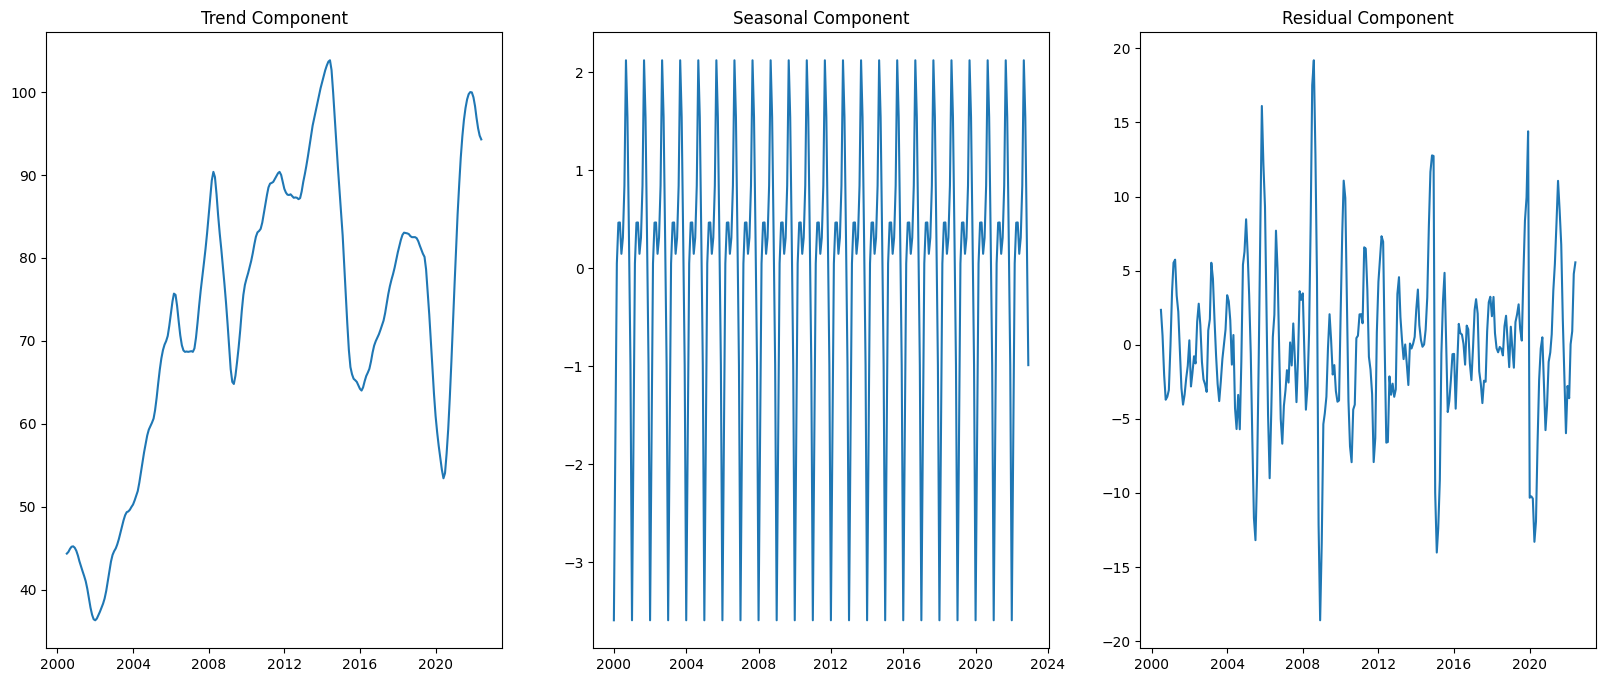

In [66]:
plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
plt.plot(trend)
plt.title('Trend Component')
plt.subplot(1,3,2)
plt.plot(seasonal)
plt.title('Seasonal Component')
plt.subplot(1,3,3)
plt.plot(residual)
plt.title('Residual Component')

plt.show()

* Other than a general upward movement, there is no clear indication of a trend.

##### Differenced Data

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform time series decomposition
decomposition = seasonal_decompose(data_diff['target'], model='additive')

# Access the decomposed components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

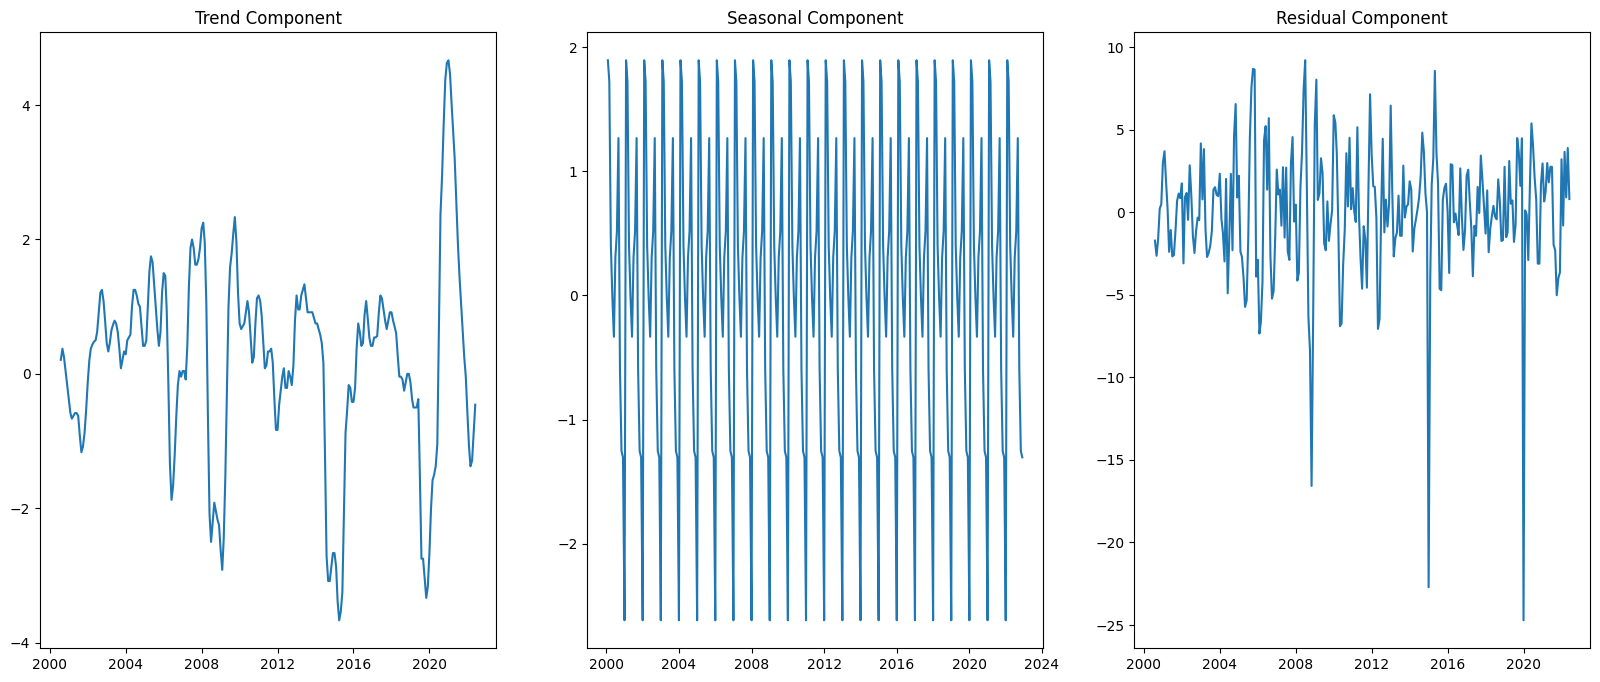

In [28]:
plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
plt.plot(trend)
plt.title('Trend Component')
plt.subplot(1,3,2)
plt.plot(seasonal)
plt.title('Seasonal Component')
plt.subplot(1,3,3)
plt.plot(residual)
plt.title('Residual Component')

plt.show()

### Identify order of the AR (autoregressive), I (integrated), and MA (moving average) processes, along with the seasonal components.

p: The lag value where the PACF cuts off (drops to 0) for the first time.
q: The lag value where the ACF chart crosses the upper confidence interval for the first time.
d: The order of differencing required to make the time series stationary.

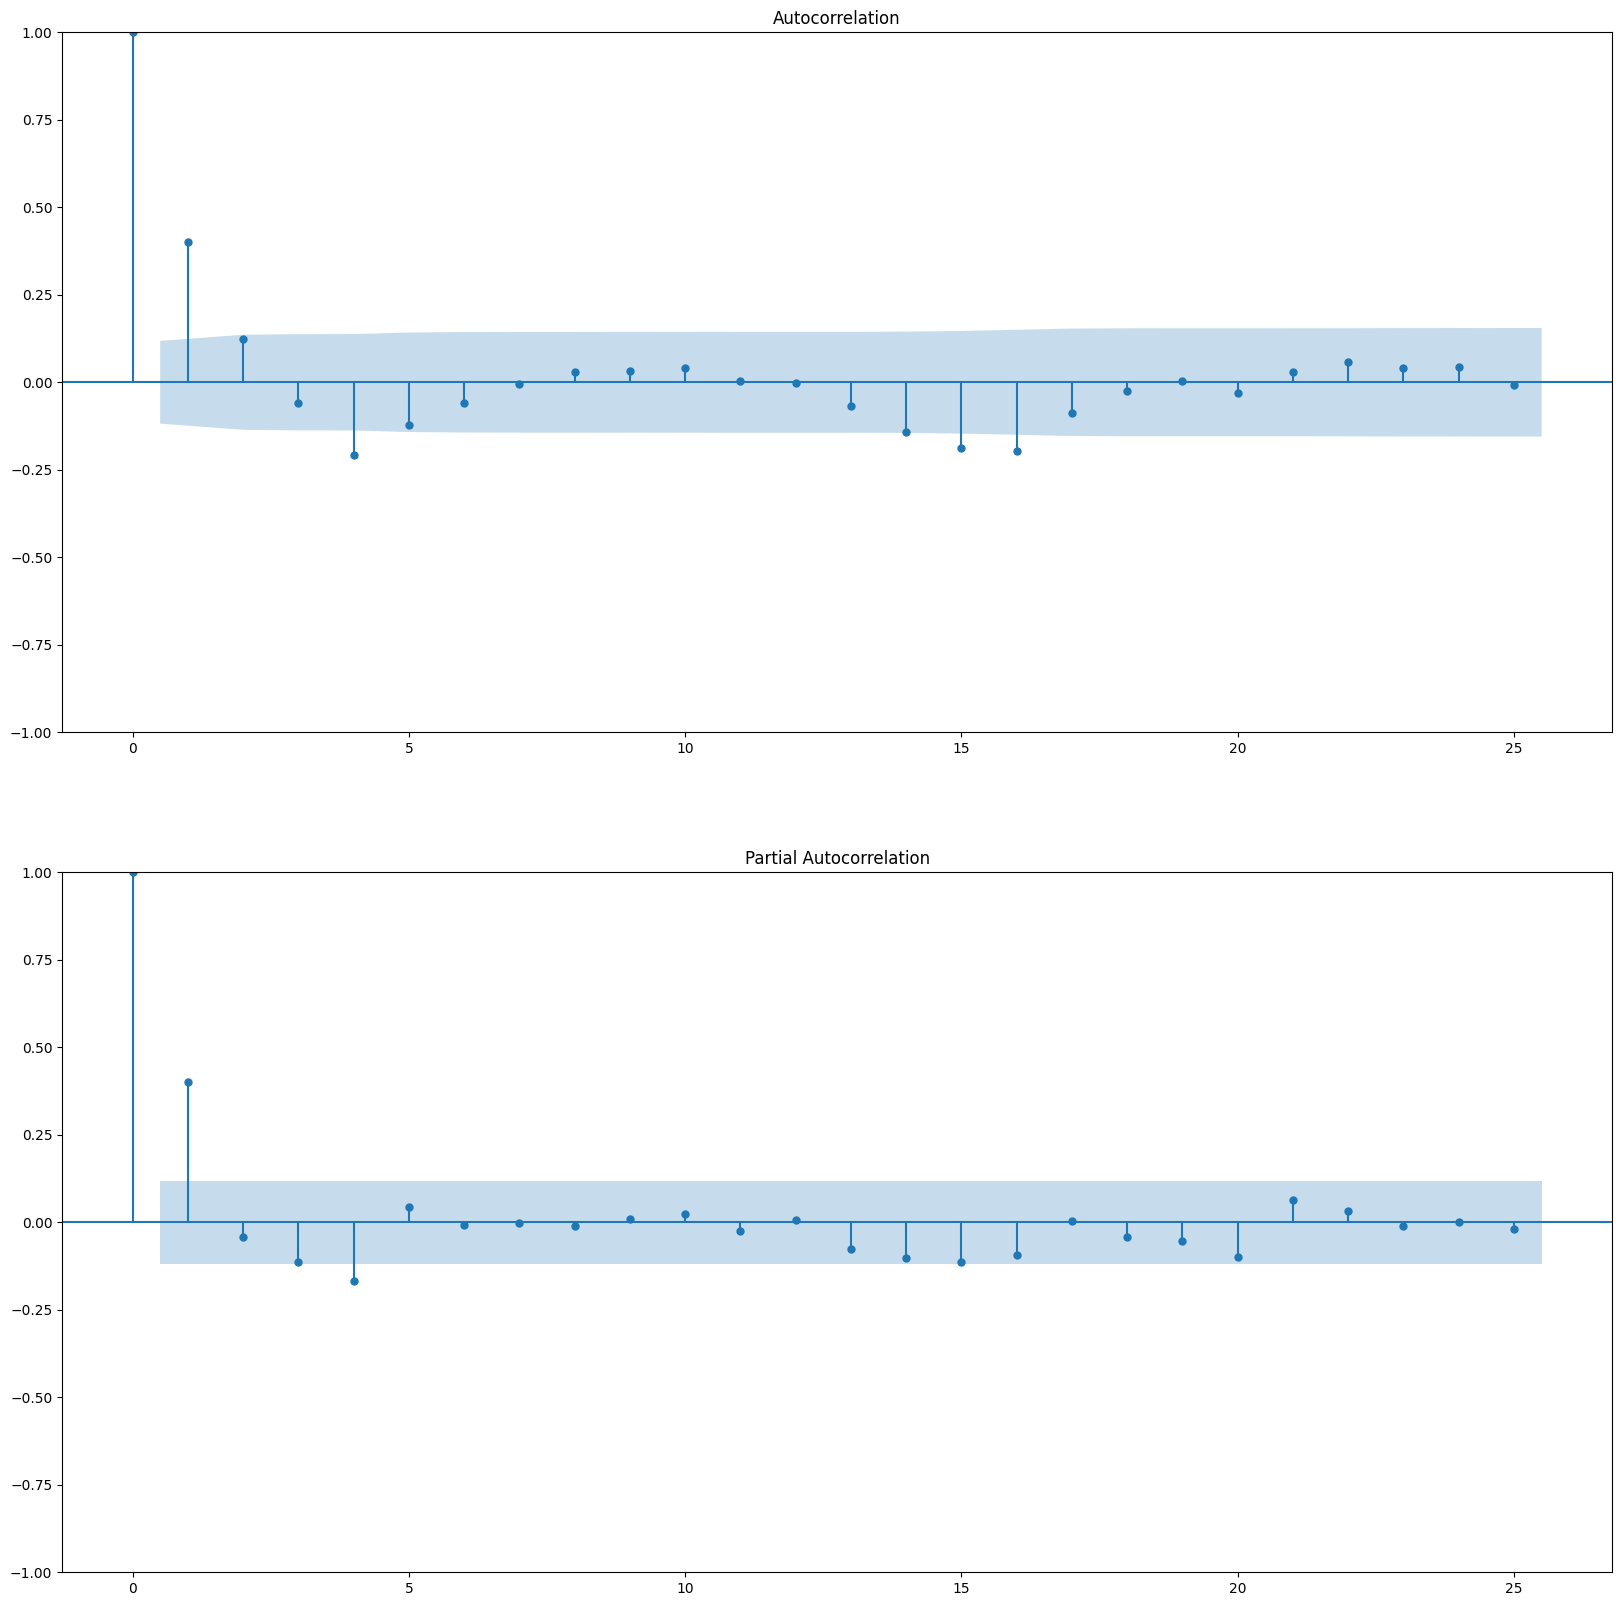

In [75]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,20))

# Plot the ACF of the differenced series
plot_acf(data_diff, ax=ax1,)

# Plot the PACF of the differenced series
plot_pacf(data_diff, ax=ax2)

plt.show()

In [44]:
from pmdarima import auto_arima

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Fit auto_arima function
stepwise_fit = auto_arima(data_diff['target'], seasonal=True, m=12,
                          suppress_warnings=True, 
                          error_action="ignore", max_order=None, stepwise=True)

# To print the summary
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  275
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -758.797
Date:                Thu, 01 Jun 2023   AIC                           1525.593
Time:                        16:41:44   BIC                           1540.060
Sample:                    02-01-2000   HQIC                          1531.399
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3465      0.047     28.558      0.000       1.254       1.439
ar.L2         -0.4283      0.035    -12.395      0.000      -0.496      -0.361
ma.L1         -0.9513      0.045    -21.211      0.000      -1.039      -0.863
sigma2        14.5691      0.404     36.026      0.000      13.776      15.362
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              5924.73
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               2.58   Skew:                            -3.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Data from before differencing.

In [64]:
from pmdarima import auto_arima

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Fit auto_arima function
stepwise_fit = auto_arima(uv_data['target'],  seasonal=True, m=12,
                          suppress_warnings=True, 
                          error_action="ignore", max_order=None, stepwise=True)

# To print the summary
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  276
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -758.797
Date:                Thu, 01 Jun 2023   AIC                           1525.593
Time:                        17:11:33   BIC                           1540.060
Sample:                    01-01-2000   HQIC                          1531.399
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3465      0.047     28.558      0.000       1.254       1.439
ar.L2         -0.4283      0.035    -12.395      0.000      -0.496      -0.361
ma.L1         -0.9513      0.045    -21.211      0.000      -1.039      -0.863
sigma2        14.5690      0.404     36.026      0.000      13.776      15.362
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              5924.73
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               2.58   Skew:                            -3.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

p = 2
d = 1
q = 1
 from Auto ARIMA 